# Bayesian Linear Regression
In this post I talk about reformulating linear regression in a Bayesian framework.
This gives us the notion of epistemic uncertainty which allows us to generate probabilistic model predictions.
I formulate a model class which can perform linear regression via Bayes rule updates.
We show the results are the same as from the `statsmodels` library.
I will also show some of the benefits of the sequential bayesian approach.

In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import time
from scipy.stats import norm
import matplotlib.pyplot as plt

plt.style.use("seaborn-whitegrid")

## Generate some dummy data
We generate some ideal data for a linear regression model so that we know the true coefficients for this example.

In [2]:
n = 10000
m = 2
np.random.seed(3)

noise_std = 2

x = np.random.uniform(-1, 1, size=(n, m))
x = np.hstack([np.ones(shape=(n, 1)), x])
w = np.random.uniform(-1, 1, size=(m + 1, 1))
y_true = x @ w
y = y_true + np.random.normal(loc=0, scale=noise_std, size=(n, 1))

print("True coefficients:\n", w)

True coefficients:
 [[-0.24831899]
 [ 0.99863554]
 [-0.88431078]]


## Fit a linear regression with `statsmodels`
The implementation of linear regression in `statsmodels` returns the standard error
of the fitted coefficients.

In [3]:
results = sm.OLS(y, x).fit()
print(results.summary())

# extract coefficient distributions
w_sm_mu = results.params
w_sm_std = np.sqrt(np.diag(results.normalized_cov_params))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.138
Model:                            OLS   Adj. R-squared:                  0.137
Method:                 Least Squares   F-statistic:                     797.0
Date:                Mon, 07 Jun 2021   Prob (F-statistic):          6.67e-322
Time:                        23:10:31   Log-Likelihood:                -21011.
No. Observations:               10000   AIC:                         4.203e+04
Df Residuals:                    9997   BIC:                         4.205e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2520      0.020    -12.736      0.0

If we received extra data we would have no choice but to retrain the model from scratch.
In the following we train the model with an increasing fraction of the data and time each instance.

In [4]:
idx = np.floor(np.linspace(0, x.shape[0], num=50))[1:]
time_iter = []

params_mu = []
params_std = []
for end_idx in idx:
    t0 = time.process_time()
    results = sm.OLS(y[: int(end_idx)], x[: int(end_idx)]).fit()
    time_iter.append(time.process_time() - t0)

    params_mu.append(results.params)
    params_std.append(np.sqrt(np.diag(results.normalized_cov_params)))

params_mu = pd.DataFrame(params_mu, index=idx)
params_std = pd.DataFrame(params_std, index=idx, columns=params_mu.columns)

As expected, we can see that training the model with increasing lengths of data causes an increasing in fitting time.

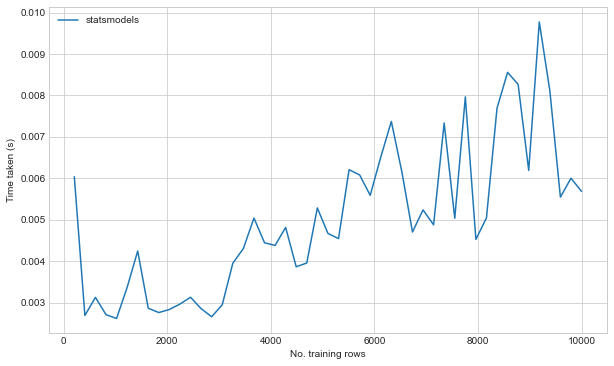

In [5]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(idx, time_iter, label="statsmodels")
ax.set_ylabel("Time taken (s)")
ax.set_xlabel("No. training rows")
plt.legend()
plt.show()

We can also show that with increasing data our estimates of the coefficients become more confident
as the standard error shrinks.
This is a measure of our epistemic (model) uncertainty.

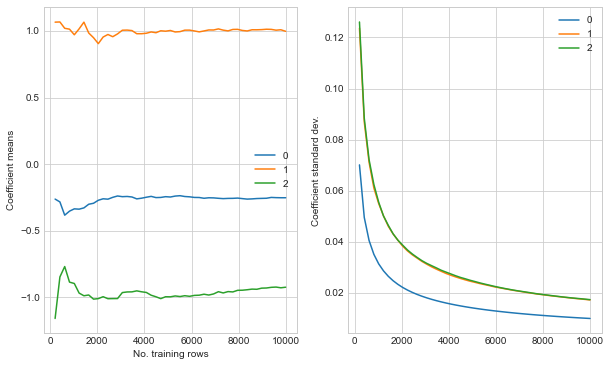

In [6]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 6))
params_mu.plot(ax=ax[0])
params_std.plot(ax=ax[1])
ax[0].set_xlabel("No. training rows")
ax[0].set_ylabel("Coefficient means")
ax[1].set_ylabel("Coefficient standard dev.")
plt.show()

## Sequential bayesian regression
Another way of approaching this problem is with sequential Bayesian regression.
This method follows Bayes theorem, where we have a prior distribution or estimates of our regression coefficients.
We then update those prior distribution with data we observe to get a posterior distribution.
We can then consider those posterior distributions as our new prior distributions and repeat the process.

Linear regression produces a multivariate normal distribution over the resulting coefficient estimates.
The conjugate prior to this is also a multivariate normal distribution prior.
As such we can formulate an analytical expression for the Bayes rule posterior update.

The update rules I used were taken from:
[https://cedar.buffalo.edu/~srihari/CSE574/Chap3/3.4-BayesianRegression.pdf](https://cedar.buffalo.edu/~srihari/CSE574/Chap3/3.4-BayesianRegression.pdf)

### Model definition
We can build this as a class withi a similar API to sklearn models:

In [7]:
class BayesLinearRegressor:
    def __init__(self, number_of_features, mean=None, cov=None, alpha=1e6, beta=1):
        # prior distribution on weights
        if mean is None:
            self.mean = np.array([[0] * (number_of_features)], dtype=np.float).T

        if cov is None:
            self.cov = alpha * np.identity(number_of_features)
            self.cov_inv = np.linalg.inv(self.cov)

        self.beta = beta  # process noise

    def fit(self, x, y):
        return self.update(x, y)

    def update(self, x, y):
        """
        Perform a bayesian update step
        """
        if len(x.shape) == 1:
            x = x[np.newaxis, :]
        if len(y.shape) == 1:
            y = y[:, np.newaxis]

        # update state of covariance and means
        cov_n_inv = self.cov_inv + self.beta * x.T @ x
        cov_n = np.linalg.inv(cov_n_inv)
        mean_n = cov_n @ (self.cov_inv @ self.mean + self.beta * x.T @ y)

        self.cov_inv = cov_n_inv
        self.cov = cov_n
        self.mean = mean_n

    def predict(self, x):
        mean = x @ self.mean
        scale = np.sqrt(np.sum(x @ self.cov @ x.T, axis=1))
        return mean, scale

    @property
    def coef_(self):
        return self.mean

    @property
    def scale_(self):
        return np.sqrt(np.diag(self.cov))

We can train the model as follows.
We use `numpy` testing to confirm the coefficient we get are equal to those of `statsmodels`.

In [8]:
bayes_linear_regression = BayesLinearRegressor(x.shape[1])
bayes_linear_regression.fit(x, y)
np.testing.assert_array_almost_equal(
    bayes_linear_regression.coef_, params_mu.tail(1).transpose().to_numpy()
)
np.testing.assert_array_almost_equal(
    bayes_linear_regression.scale_, params_std.tail(1).to_numpy().flatten()
)

ipykernel_launcher:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


### Sequential training
We can now train the model with chunks of data.
We will time the models fitting and track the coefficients with extra data.

In [9]:
bayes_linear_regression = BayesLinearRegressor(x.shape[1])

time_iter_seq = []
params_mu_seq = []
params_std_seq = []
for i, end_idx in enumerate(idx):
    t0 = time.process_time()
    if i > 0:
        start_idx = int(idx[i - 1])
    else:
        start_idx = 0
    bayes_linear_regression.update(
        x[start_idx : int(end_idx)],
        y[start_idx : int(end_idx)],
    )
    time_iter_seq.append(time.process_time() - t0)

    params_mu_seq.append(bayes_linear_regression.coef_.flatten())
    params_std_seq.append(bayes_linear_regression.scale_)

params_mu_seq = pd.DataFrame(params_mu_seq, index=idx, columns=params_mu.columns)
params_std_seq = pd.DataFrame(params_std_seq, index=idx, columns=params_mu.columns)

ipykernel_launcher:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


The time taken to train with each chunk is approximately the same.
As such, we can fit an initial model and continue to update it as an alternative to fitting a single large model.

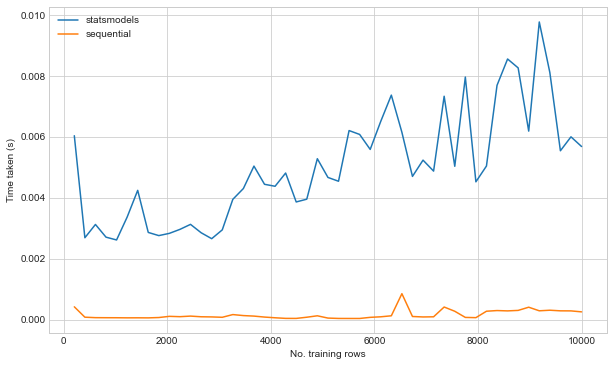

In [10]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(idx, time_iter, label="statsmodels")
ax.plot(idx, time_iter_seq, label="sequential")
# ax.plot(idx, np.cumsum(time_iter_seq), label="cumulative_sequential")
ax.set_ylabel("Time taken (s)")
ax.set_xlabel("No. training rows")
plt.legend()
plt.show()

The model coefficients behave as before.
E.g. we can similarly show that the standard deviation of the coefficients reduces with data length.

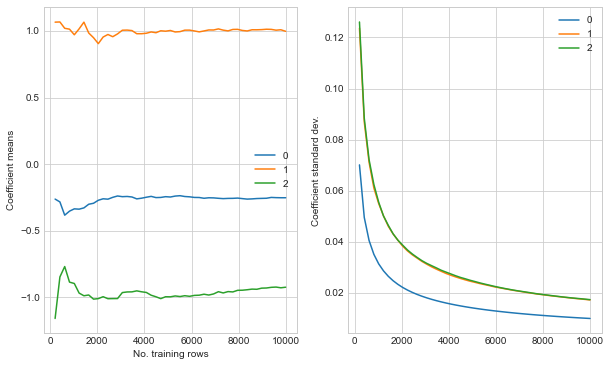

In [11]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 6))
params_mu_seq.plot(ax=ax[0])
params_std_seq.plot(ax=ax[1])
ax[0].set_xlabel("No. training rows")
ax[0].set_ylabel("Coefficient means")
ax[1].set_ylabel("Coefficient standard dev.")
plt.show()

### Posteriors vs Priors
One of the benefits of using bayesian linear regression is the ability to apply prior distributions
on the model coefficients.
To demonstrate this we use a prior with a much smaller variance, as such it is no longer uninformed.
We fit the model and plot the pdf of the prior and posterior.
The posteriors evidently converge to the true coefficients and have a tight distribution.

ipykernel_launcher:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


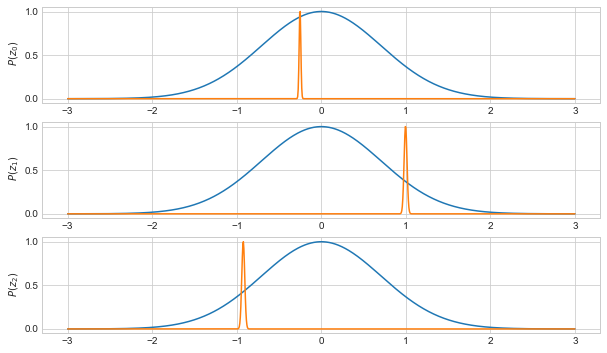

In [12]:
bayes_linear_regression = BayesLinearRegressor(x.shape[1], alpha=0.5)
prior_mu = bayes_linear_regression.coef_
prior_std = bayes_linear_regression.scale_
bayes_linear_regression.fit(x, y)


def norm_max(x):
    return x / x.max()


x_range = np.linspace(-3, 3, num=1000)
fig, ax = plt.subplots(nrows=m + 1, figsize=(10, 6))
for idx in range(m + 1):
    ax[idx].plot(
        x_range,
        norm_max(norm.pdf(x_range, loc=prior_mu[idx], scale=prior_std[idx])),
    )
    ax[idx].plot(
        x_range,
        norm_max(
            norm.pdf(
                x_range,
                loc=params_mu_seq.iloc[-1, idx],
                scale=params_std_seq.iloc[-1, idx],
            )
        ),
    )
    ax[idx].set_ylabel(f"$~P(z_{idx})$")

### Prediction uncertainty
The distribution of our coefficients gives us a distribution for our model predictions as well.

The predict method of the `BayesLinearRegressor` class returns a standard deviation for each point.
We can then plot a few of those points with this confidence shaded.
This only represents epistemic uncertainty - i.e. uncertainty from our model coefficients,
not uncertainty from the data generating process.

ipykernel_launcher:7: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


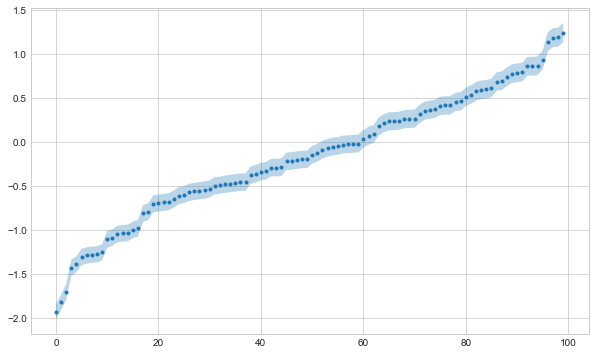

In [13]:
bayes_linear_regression = BayesLinearRegressor(x.shape[1])
bayes_linear_regression.fit(x, y)
pred_mu, pred_scale = bayes_linear_regression.predict(x[:100])

sort_id = np.argsort(pred_mu.flatten())

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(pred_mu[sort_id].flatten(), ".")

ax.fill_between(
    np.arange(100),
    pred_mu[sort_id].flatten() - pred_scale[sort_id],
    pred_mu[sort_id].flatten() + pred_scale[sort_id],
    alpha=0.3,
)

### Adaptive learning
By updating sequential with data as it appears we can learn from data that may not be stationary.
A sequential model can do some form of tracking if the coefficients need to change with time.

More on this to come...